In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from scipy.stats import spearmanr
from scipy.signal import find_peaks, detrend
import pywt
from numpy import arange, array, linspace, loadtxt, log2, logspace, mean, polyfit
from numpy import zeros, pi, sin, cos, arctan2, sqrt, real, imag, conj, tile
from numpy import round, interp, diff, unique, where
from pandas import DataFrame, date_range
import matplotlib.dates as mdates
from matplotlib import pyplot
from scipy.stats import pearsonr, mannwhitneyu, kruskal, norm, wasserstein_distance
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score, recall_score, precision_score,roc_auc_score, roc_curve, auc,accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import keras.backend as K
from keras.utils import Sequence

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict, Counter


import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras import layers
# from tensorflow.keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Concatenate,Input,Dropout, Conv2D, MaxPooling2D, Flatten,Multiply,Attention,Dense,concatenate,Masking,BatchNormalization, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
history = History()

import pickle
import joblib
import dill
import json
from collections import defaultdict
from scipy.signal import savgol_filter
import gc

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import sys
sys.stderr = open(os.devnull, 'w')

2025-04-05 07:28:46.897837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 07:28:46.911572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 07:28:46.915586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743838316.822648 2467077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743838316.837072 2467077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743838316.837722 2467077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [5]:
# Configure GPUs to grow memory as needed
def configure_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

def plot_training_history(folds_val_loss, folds_val_auc, folds_val_acc, folder):
    # Determine max_epochs as the minimum length of the folds minus 10
    max_epochs = min(len(fold) for fold in folds_val_auc) - 10

    # Initialize arrays to store average and standard deviation for each epoch
    avg_loss = np.zeros(max_epochs)
    std_loss = np.zeros(max_epochs)
    avg_auc = np.zeros(max_epochs)
    std_auc = np.zeros(max_epochs)
    avg_acc = np.zeros(max_epochs)
    std_acc = np.zeros(max_epochs)

    # Compute average and standard deviation for each epoch
    for epoch in range(max_epochs):
        losses = []
        aucs = []
        accuracies = []
        for fold_loss, fold_auc, fold_acc in zip(folds_val_loss, folds_val_auc, folds_val_acc):
            if epoch < len(fold_loss):
                losses.append(fold_loss[epoch])
            if epoch < len(fold_auc):
                aucs.append(fold_auc[epoch])
            if epoch < len(fold_acc):
                accuracies.append(fold_acc[epoch])
        if losses:
            avg_loss[epoch] = np.mean(losses)
            std_loss[epoch] = np.std(losses)
        if aucs:
            avg_auc[epoch] = np.mean(aucs)
            std_auc[epoch] = np.std(aucs)
        if accuracies:
            avg_acc[epoch] = np.mean(accuracies)
            std_acc[epoch] = np.std(accuracies)

    # Adjusted x-axis range: 1 to 3*max_epochs + 1 with step size of 3
    epochs_range = range(1, 3 * max_epochs + 1, 3)

    # Plot average loss, AUC, and accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, avg_loss, color='blue', label='Validation Loss')
    plt.fill_between(epochs_range, 
                     avg_loss - std_loss,
                     avg_loss + std_loss,
                     color='blue', alpha=0.2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Validation Loss per Epoch', fontsize=14)
    plt.legend(fontsize=10)

    # AUC plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, avg_auc, color='blue', label='Validation AUC')
    plt.fill_between(epochs_range, 
                     avg_auc - std_auc,
                     avg_auc + std_auc,
                     color='blue', alpha=0.2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.title('Validation AUC per Epoch', fontsize=14)
    plt.legend(fontsize=10)

    # Accuracy plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, avg_acc, color='blue', label='Validation Accuracy')
    plt.fill_between(epochs_range, 
                     avg_acc - std_acc,
                     avg_acc + std_acc,
                     color='blue', alpha=0.2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Validation Accuracy per Epoch', fontsize=14)
    plt.legend(fontsize=10)

    # Tight layout and save
    plt.tight_layout()
    plot_path = os.path.join(folder, 'loss_auc_accuracy_plot.png')
    plt.savefig(plot_path)
    print(f"Plot saved at: {plot_path}")
    plt.show()

def apply_smote_resampling_cgm(X_matrices, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)

    # Combine all inputs into a single 2D array for SMOTE
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3)
    ])

    # Apply SMOTE to the combined array and the target
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    # Extract the resampled components
    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)

    return (X_matrices_resampled, 
            y_resampled)
def apply_smote_resampling(X_matrices, X_features_daily, X_features_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)

    # Combine all inputs into a single 2D array for SMOTE
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual
    ])

    # Apply SMOTE to the combined array and the target
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    # Extract the resampled components
    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:]
    
    return X_matrices_resampled, X_features_daily_resampled, X_features_individual_resampled, y_resampled

def initialize_results():
    return {
        "fold_model": [], "train_acc": [], "val_acc": [], "accuracy_scores": [], "recall_scores": [],"precision_scores": [], "f1_scores": [], "roc_auc_scores": [], "specificity_scores": [],
        "mae": [], "mse": [],"fold_train_loss": [],"fold_train_auc": [],"fold_train_acc": [],"fold_val_loss": [],"fold_val_auc": [],"fold_val_acc": [],
        "conf_matrix": [], "class_report": [],"train_loss": [],"train_acc": [],"val_loss": [],"val_acc": [],
    }

def prepare_datasets(file_path):
    """
    Loads and processes dataset from the given file path.
    Filters data, extracts relevant features and labels, applies normalization, 
    and prepares input matrices for analysis.

    Args:
        file_path (str): Path to the dataset file.

    Returns:
        tuple: matrices, daily_features, individual_features, labels, participant_ids
    """
    
    # Load data
    with open(file_path, "rb") as f:
        data_dict = dill.load(f)
    
    # Filter data
    if len(data_dict)>350:
        filtered_data_dict = {}
        for participant_id, days_data in data_dict.items():
            filtered_days_data = [day_data for current_date, day_data in days_data.items()
                                  if (day_data['len_original_cgm'] > 252 and 
                                      np.sum(day_data['CGM_stats_daily_original'].isna()).sum() < 1)]
            if filtered_days_data:
                filtered_data_dict[participant_id] = filtered_days_data
    else:
        filtered_data_dict = data_dict
    
    del data_dict
    # Initialize data structures
    participant_ids = []
    X_features_individual, X_features_daily = [], []
    X_matrices_power = []
    labels = { 
        "hypo_early_night": [], "hypo_night": [], "hypo_long_night": [],
        "hypo_night_morning": [], "hyper_day": [], "hypo_late_night": [],
        "hyper_night": [], "hyper_early_night": [], "hypo_morning": [],
        "hypo_day": []
    }
    
    # Process data
    for participant_id, days_data in filtered_data_dict.items():
        participant_ids.extend([participant_id] * len(days_data))
        for day_data in days_data:
            X_matrices_power.append(day_data['full_matrix_cgm_power'])
            X_features_daily.append(np.concatenate([
                day_data['CGM_stats_daily_original'],
                day_data['Basal_stats_daily'],
                day_data['Carbs_stats_daily'],
                day_data['HR_stats_daily']], axis=1))
            X_features_individual.append(np.concatenate([
                [[day_data['A1c']]],
                [[day_data['Weight']]],
                [[day_data['Height']]],
                day_data['CGM_stats_participant'],
                day_data['Basal_stats_participant'],
                day_data['HR_stats_participant']], axis=1))
            
            for label in labels.keys():
                labels[label].append(day_data['next_day_cgm_labels_original'][label])
    
    # Convert lists to numpy arrays
    participant_ids = np.array(participant_ids)
    X_matrices_power = np.array(X_matrices_power)
    X_features_daily = np.array(X_features_daily)
    X_features_individual = np.array(X_features_individual)
    for key in labels:
        labels[key] = np.array(labels[key], dtype=np.float32)
    
    # Standardization function
    def standard_scale(data):
        scaler = StandardScaler()
        data[np.isinf(data)] = np.nan  # Replace infinities with NaN
        return scaler.fit_transform(data.reshape(-1, data.shape[-1]))
    
    # Apply standardization
    individual_features = standard_scale(X_features_individual)
    daily_features = standard_scale(X_features_daily)
    
    # # Function to check for NaNs
    # def check_nans(arr, name):
    #     print(f"{name}: {np.isnan(arr).sum()} NaNs found, shape: {arr.shape}")
    
    # print('Checking for NaNs in the data...')
    # check_nans(X_matrices_power, "X_matrices_power")
    # check_nans(individual_features, "X_features_individual_scaled")
    # check_nans(daily_features, "X_features_daily_scaled")
    # for key in labels:
    #     check_nans(labels[key], f"y_label {key}")
    
    del filtered_data_dict, X_features_daily, X_features_individual    
    # Manual standard scaling for matrices
    def manual_standard_scaling(matrix):
        return matrix / np.nanstd(matrix)
    
    matrices = np.zeros_like(X_matrices_power)
    for i in range(X_matrices_power.shape[0]):
        for channel in range(3):  # Assuming 3 channels in last dimension
            matrices[i, :, :, channel] = manual_standard_scaling(X_matrices_power[i, :, :, channel])
    
    del X_matrices_power
    gc.collect()
    
    return matrices, daily_features, individual_features, labels, participant_ids
 
# Attention mechanism
def attention_block(x):
    attention = Conv2D(32, kernel_size=(1, 1), activation='relu')(x)
    attention = BatchNormalization()(attention)
    attention = GlobalMaxPooling2D()(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    attention = Multiply()([x, attention])
    return attention

def create_model_1d():
    # Define the CNN Model
    input_matrix = Input(shape=(matrix_shape0, 288, 3), name='input_matrix')
    
    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(input_matrix)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1 = attention_block(conv1)  # Add attention here

    conv2 = Conv2D(64, kernel_size=(3, 3), dilation_rate=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Convolution Block 3 with Spatial Pyramid Pooling
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and concatenate with feature vectors
    flat = Flatten()(conv3)
    dense_flat = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(flat)
    attention_flat = Dense(1024, activation='softmax')(dense_flat)
    attention_flat = Multiply()([dense_flat, attention_flat])

    densed_fully = Dense(256, activation='relu')(attention_flat)
    densed_fully = Dropout(0.5)(densed_fully)
    
    fc_additional = Dense(128, activation='relu')(densed_fully)
    output = Dense(1, activation='sigmoid', dtype='float32')(fc_additional)
    model = Model(inputs=input_matrix, outputs=output)
    model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model
def create_model_cgm():
    # Define the CNN Model
    input_matrix = Input(shape=(matrix_shape0, 288, 3), name='input_matrix')
    input_features_daily = Input(shape=(dailyshape,), name='input_features_daily')
    input_features_individual = Input(shape=(individualshape,), name='input_features_individual')

    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(input_matrix)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1 = attention_block(conv1)  # Add attention here

    conv2 = Conv2D(64, kernel_size=(3, 3), dilation_rate=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Convolution Block 3 with Spatial Pyramid Pooling
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and concatenate with feature vectors
    flat = Flatten()(conv3)
    dense_flat = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(flat)
    attention_flat = Dense(1024, activation='softmax')(dense_flat)
    attention_flat = Multiply()([dense_flat, attention_flat])

    densed_fully = Dense(512, activation='relu')(attention_flat)
    densed_fully = Dropout(0.5)(densed_fully)
    dense_daily = Dense(128, activation='relu')(input_features_daily)
    dense_individual = Dense(128, activation='relu')(input_features_individual)
    
    # Combine feature inputs
    concat_features = concatenate([dense_daily, dense_individual])
    # Cross-Attention mechanism to extract relevant parts of both feature vectors
    attention_weights = Dense(256, activation='softmax')(concat_features)
    attention_features = Multiply()([concat_features, attention_weights])
    # Combine all inputs
    concat_all = concatenate([densed_fully, attention_features])
    
    fc_combined = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(concat_all)
    fc_combined = Dropout(0.6)(fc_combined)

    attention_fc_combined = Dense(256, activation='relu')(fc_combined)
    attention_fc_combined = Dropout(0.7)(attention_fc_combined)
    
    fc_additional = Dense(128, activation='relu')(attention_fc_combined)
    output = Dense(1, activation='sigmoid')(fc_additional)
    # Define the model
    model = Model(inputs=[input_matrix, input_features_daily, input_features_individual], outputs=output)
    model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy','AUC'])
    return model
def create_model_mask():
    # Define the CNN Model
    input_matrix = Input(shape=(matrix_shape0, 288, 3), name='input_matrix')
    input_features_daily = Input(shape=(dailyshape,), name='input_features_daily')
    input_features_individual = Input(shape=(individualshape,), name='input_features_individual')
    input_mask_daily = Input(shape=(dailyshape,), name='input_mask_daily')
    input_mask_individual = Input(shape=(individualshape,), name='input_mask_individual')
    
    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(input_matrix)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1 = attention_block(conv1)  # Add attention here

    conv2 = Conv2D(64, kernel_size=(3, 3), dilation_rate=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Convolution Block 3 with Spatial Pyramid Pooling
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and concatenate with feature vectors
    flat = Flatten()(conv3)
    dense_flat = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(flat)
    # attention_flat = Dense(1024, activation='softmax')(dense_flat)
    # attention_flat = Multiply()([dense_flat, attention_flat])

    densed_fully = Dense(512, activation='relu')(dense_flat)
    densed_fully = Dropout(0.5)(densed_fully)

    # Masked dense layers for the daily features
    masked_daily = Multiply()([input_features_daily, input_mask_daily])  # Apply mask to daily features
    dense_daily = Dense(128, activation='relu')(masked_daily)
    
    # Masked dense layers for the individual features
    masked_individual = Multiply()([input_features_individual, input_mask_individual])
    dense_individual = Dense(128, activation='relu')(masked_individual)
    
    # Combine feature inputs
    concat_features = concatenate([dense_daily, dense_individual])
    
    # Cross-Attention mechanism to extract relevant parts of both feature vectors
    attention_weights = Dense(256, activation='softmax')(concat_features)
    attention_features = Multiply()([concat_features, attention_weights])
    
    # Combine all inputs
    concat_all = concatenate([densed_fully, attention_features])
    
    fc_combined = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(concat_all)
    fc_combined = Dropout(0.6)(fc_combined)

    attention_fc_combined = Dense(256, activation='relu')(fc_combined)
    attention_fc_combined = Dropout(0.7)(attention_fc_combined)
    
    fc_additional = Dense(128, activation='relu')(attention_fc_combined)
    output = Dense(1, activation='sigmoid', dtype='float32')(fc_additional)
    model = Model(inputs=[input_matrix, input_features_daily, input_features_individual, input_mask_daily, input_mask_individual], outputs=output)
    model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model
    
# Function to create an efficient TF dataset
def prepare_tf_dataset(X_matrix, X_features1, X_features2, X_mask1, X_mask2, y, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(((X_matrix, X_features1, X_features2, X_mask1, X_mask2), y))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(y), reshuffle_each_iteration=True)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset
def prepare_tf_dataset_mask(X_matrix, X_features1, X_features2,X_mask1, X_mask2, y, batch_size=16, shuffle=True):
    def data_generator():
        for i in range(len(y)):
            yield (X_matrix[i], X_features1[i], X_features2[i], X_mask1[i], X_mask2[i]), y[i]
    
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(288, 288, 3), dtype=tf.float64),  # Matrix input
                tf.TensorSpec(shape=(dailyshape,), dtype=tf.float16),         # Feature vector 1
                tf.TensorSpec(shape=(individualshape,), dtype=tf.float64),          # Feature vector 2
                tf.TensorSpec(shape=(dailyshape,), dtype=tf.float16),         # Mask vector 1
                tf.TensorSpec(shape=(individualshape,), dtype=tf.float16)          # Mask vector 2            
            ),
            tf.TensorSpec(shape=(), dtype=tf.float16)  # Target variable
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(y), reshuffle_each_iteration=True)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset
 
def get_train_val_test_indices(participant_ids, train_val_idx, test_idx):
    model_participants = np.unique(participant_ids)
    model_participants = shuffle(model_participants, random_state=42)
    # 75% of the data as train set
    train_val_participants = model_participants[np.isin(model_participants, participant_ids[train_val_idx])]
    test_participants = model_participants[np.isin(model_participants, participant_ids[test_idx])]
    train_size = int(len(train_val_participants) * 8 / 9)
    train_participants = train_val_participants[:train_size]
    val_participants = train_val_participants[train_size:]
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )
    
    train_idx = np.where(np.isin(participant_ids, train_participants))[0]
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    return train_idx, val_idx

def train_and_evaluate_resampled_model_mask(fold, train_idx, val_idx, X_matrix,X_daily_features,X_individual_features, y_labels, num_epochs=40, batch_s=16, num_patience=20, monitored='val_loss'):
    model = create_model_3d()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitored, patience=num_patience, restore_best_weights=True)
    learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitored, factor=0.5, patience=4, min_lr=1e-7)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')

    X_train_resampled,X_daily_train_resampled,X_individual_train_resampled, y_label_train_resampled = apply_smote_resampling(
        X_matrix[train_idx],X_daily_features[train_idx],X_individual_features[train_idx],
        y_labels[train_idx], matrix_shape0=matrix_shape0
    )
    X_val_resampled,X_daily_val_resampled,X_individual_val_resampled, y_label_val_resampled = apply_smote_resampling(
        X_matrix[val_idx],X_daily_features[val_idx],X_individual_features[val_idx],
        y_labels[val_idx], matrix_shape0=matrix_shape0
    )
    train_dataset = prepare_tf_dataset(X_train_resampled,X_daily_train_resampled,X_individual_train_resampled, y_label_train_resampled, batch_size=batch_s)
    val_dataset = prepare_tf_dataset(X_val_resampled,X_daily_val_resampled,X_individual_val_resampled, y_label_val_resampled, batch_size=batch_s, shuffle=False)
    del X_train_resampled,X_daily_train_resampled,X_individual_train_resampled, y_label_train_resampled
    del X_val_resampled,X_daily_val_resampled,X_individual_val_resampled, y_label_val_resampled
    # gc.collect()
    history = model.fit(train_dataset, epochs=num_epochs, verbose=1, validation_data=val_dataset, callbacks=[early_stopping, learning_rate_scheduler, checkpoint])
    model.load_weights(os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)))
    del train_dataset, val_dataset, early_stopping, learning_rate_scheduler, checkpoint
    gc.collect()
    return model, history
    
def train_and_evaluate_model_mask(fold, train_idx,val_idx, X_matrix, X_daily_features,X_individual_features, mask_daily, mask_individual, y_labels, num_epochs=40, batch_s=16, num_patience=20, monitored='val_loss'):
    model = create_model_mask()

    early_stopping = keras.callbacks.EarlyStopping(monitor=monitored, patience=num_patience, restore_best_weights=True)
    learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau(monitor=monitored, factor=0.5, patience=8, min_lr=1e-7)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_loss', save_best_only=True, mode='min')
    train_dataset = prepare_tf_dataset(X_matrix[train_idx], X_daily_features[train_idx], X_individual_features[train_idx],mask_daily[train_idx], mask_individual[train_idx], y_labels[train_idx], batch_size=batch_s)
    val_dataset = prepare_tf_dataset(X_matrix[val_idx], X_daily_features[val_idx], X_individual_features[val_idx],mask_daily[val_idx], mask_individual[val_idx], y_labels[val_idx], batch_size=batch_s, shuffle=False)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_labels[train_idx]), y=y_labels[train_idx].ravel())
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history = model.fit(train_dataset, epochs=num_epochs, verbose=1, validation_data=val_dataset, callbacks=[early_stopping, learning_rate_scheduler,checkpoint],class_weight=class_weight_dict)
    model.load_weights(os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)))

    del train_dataset, val_dataset
    gc.collect()
    return model, history

def evaluate_performance_mask(model, test_idx, X_matrices, X_daily_features, X_individual_features,mask_daily, mask_individual, y_labels, threshold=0.3):
    y_pred_test = model.predict([X_matrices[test_idx], X_daily_features[test_idx], X_individual_features[test_idx],mask_daily[test_idx], mask_individual[test_idx]])
    y_pred_test_binary = (y_pred_test >= threshold).astype(int)
    
    return {
        "accuracy_scores": accuracy_score(y_labels[test_idx], y_pred_test_binary),
        "recall_scores": recall_score(y_labels[test_idx], y_pred_test_binary),
        "precision_scores": precision_score(y_labels[test_idx], y_pred_test_binary),
        "f1_scores": f1_score(y_labels[test_idx], y_pred_test_binary),
        "specificity_scores": recall_score(y_labels[test_idx], y_pred_test_binary, pos_label=0),
        "roc_auc_scores": roc_auc_score(y_labels[test_idx], y_pred_test),
        "conf_matrix": confusion_matrix(y_labels[test_idx], y_pred_test_binary)}

def get_target_results_mask(models, num_splits, X_matrices, X_daily_features, X_individual_features,mask_daily, mask_individual,participant_ids, y_labels):
    # Initialize arrays to store predictions from each fold
    y_pred_target_agg = np.zeros((len(y_labels),)) 
    # Aggregate predictions from each fold model
    for model in models:
        y_pred_target_fold = model.predict([X_matrices, X_daily_features, X_individual_features,mask_daily, mask_individual])
        y_pred_target_agg += y_pred_target_fold.flatten()  # Accumulate predictions
        y_pred_target_avg = np.mean(y_pred_target_fold, axis=0)
    # Average the predictions from all folds
    y_pred_target_agg /= num_splits
    
    y_pred_target_binary_agg = (y_pred_target_agg >= 0.39).astype(int) 
    conf_matrix = confusion_matrix(y_labels, y_pred_target_binary_agg)
    
    # Compute recall per participant
    df_results = pd.DataFrame({
        "participant_id": participant_ids.astype(int),
        "y_true": y_labels.flatten(),
        "y_pred_binary": y_pred_target_binary_agg
    })

    recall_per_participant = df_results.groupby("participant_id").apply(lambda g: recall_score(g["y_true"], g["y_pred_binary"]) if sum(g["y_true"]) > 0 else np.nan)

    return {
        "accuracy_scores": accuracy_score(y_labels, y_pred_target_binary_agg),
        "recall_scores": recall_score(y_labels, y_pred_target_binary_agg),
        "recall_scores_per_participant": recall_per_participant,
        "precision_scores": precision_score(y_labels, y_pred_target_binary_agg),
        "f1_scores": f1_score(y_labels, y_pred_target_binary_agg),
        "specificity_scores": recall_score(y_labels, y_pred_target_binary_agg, pos_label=0),
        "roc_auc_scores": roc_auc_score(y_labels, y_pred_target_agg),
        "conf_matrix": confusion_matrix(y_labels, y_pred_target_binary_agg)
    }

def cross_validation_holdout_analysis(label_name, num_splits=7, num_epochs=30, batch_s=32, num_patience=10, monitored='val_loss',threshold=0.3):
    configure_gpu()
    results = initialize_results()
    # group_kfold = GroupKFold(n_splits=num_splits)
    file_path = '/home/ma98/data_generated/Adult/dict_3d_cgm_mex_morl_smooth_updated.dill'
    X_matrices, X_daily_features, X_individual_features, labels, participant_ids = prepare_datasets(file_path)
    y_labels = labels[label_name]
    model_participants = np.unique(participant_ids)
    # model_participants = shuffle(model_participants, random_state=42)
    participant_labels = []
    participant_sample_indices = []
    
    for participant in model_participants:
        idx = np.where(participant_ids == participant)[0]
        participant_sample_indices.append(idx)
        label_values = y_labels[idx]
        participant_labels.append(int(np.any(label_values == 1)))  # binary: 1 if any day is positive
    
    participant_labels = np.array(participant_labels)
    sgkf = MultilabelStratifiedKFold(num_splits, shuffle=True, random_state=42)

    with tf.distribute.MirroredStrategy().scope():
        # for fold, (train_val_idx, test_idx) in enumerate(group_kfold.split(X_matrices, y_labels, groups=participant_ids)):
        for fold, (train_val_group_idx, test_group_idx) in enumerate(
            sgkf.split(model_participants.reshape(-1, 1), 
                       np.vstack((1 - participant_labels, participant_labels)).T)
        ):            
            train_val_participants = model_participants[train_val_group_idx]
            test_participants = model_participants[test_group_idx]
        
            # Step 4: Map back to sample indices
            train_val_idx = np.concatenate([np.where(participant_ids == p)[0] for p in train_val_participants])
            test_idx = np.concatenate([np.where(participant_ids == p)[0] for p in test_participants])

            train_idx, val_idx = get_train_val_test_indices(participant_ids, train_val_idx, test_idx)
            print(f"Processing fold {fold + 1}...")
            X_daily_imputed = np.nan_to_num(X_daily_features, nan=0.0)
            X_individual_imputed = np.nan_to_num(X_individual_features, nan=0.0)
            
            # Create masks for missing values
            mask_daily = np.isfinite(X_daily_features).astype(np.float16)
            mask_individual = np.isfinite(X_individual_features).astype(np.float16)

            model, model_history = train_and_evaluate_model_mask(fold, train_idx,  val_idx, X_matrices, X_daily_imputed, X_individual_imputed,mask_daily, mask_individual, y_labels, 
                                                                 num_epochs, batch_s, num_patience, monitored)
    
            fold_results = evaluate_performance_mask(model, test_idx, X_matrices, X_daily_imputed, X_individual_imputed,mask_daily, mask_individual, y_labels, threshold)
            
            for key in results.keys():
                if key in fold_results.keys():
                    results[key].append(fold_results[key])
            results["fold_model"].append(model)
            results["fold_train_acc"].append(model_history.history['accuracy'])
            results["fold_train_auc"].append(model_history.history['AUC'])
            results["fold_train_loss"].append(model_history.history['loss'])
            results["fold_val_acc"].append(model_history.history['val_accuracy'])
            results["fold_val_auc"].append(model_history.history['val_AUC'])
            results["fold_val_loss"].append(model_history.history['val_loss'])
            
            print(f"\nFold {fold + 1} - {fold_results}")
            print("\n", fold_results["roc_auc_scores"])
            # Free GPU memory
            del model, model_history,fold_results
            gc.collect()
    del X_matrices, X_daily_features, X_individual_features, labels, participant_ids
    gc.collect()
    # Calculate and print average and std across folds
    print(f'\nAverage Test Accuracy: {np.mean(results["accuracy_scores"]):.4f} (+- {np.std(results["accuracy_scores"]):.4f})')
    print(f'Average Test Recall: {np.mean(results["recall_scores"]):.4f} (+- {np.std(results["recall_scores"]):.4f})')
    print(f'Average Test Specificity: {np.mean(results["specificity_scores"]):.4f} (+- {np.std(results["specificity_scores"]):.4f})')
    print(f'Average Test AUC: {np.mean(results["roc_auc_scores"]):.4f} (+- {np.std(results["roc_auc_scores"]):.4f})')

    print(f"Aggregated Models on Pediatric set ... \n")
    file_path = '/home/ma98/data_generated/Pediatric/FullFeatures/full_pediatric_cgm_mex_morl_smooth.dill'
    target_matrices, target_daily_features, target_individual_features, labels,target_participant_ids = prepare_datasets(file_path)
    target_labels = labels[label_name]
    target_daily_imputed = np.nan_to_num(target_daily_features, nan=0.0)
    target_individual_imputed = np.nan_to_num(target_individual_features, nan=0.0)
    
    # Create masks for missing values
    target_mask_daily = np.isfinite(target_daily_features).astype(np.float16)
    target_mask_individual = np.isfinite(target_individual_features).astype(np.float16)
    target_results = get_target_results_mask(results["fold_model"],num_splits, target_matrices, target_daily_imputed, target_individual_imputed,target_mask_daily,target_mask_individual,target_participant_ids, target_labels)

    print(f'Target Accuracy: {target_results["accuracy_scores"]:.4f}')
    print(f'Target Recall: {target_results["recall_scores"]:.4f}')
    print(f'Target Specificity: {target_results["specificity_scores"]:.4f}')
    print(f'Target ROC AUC: {target_results["roc_auc_scores"]:.4f} \n')
    
    pediatric_hbA1c_values = target_individual_features[:, 0] 
    # y_true = target_labels
    # y_pred_binary = (target_results["recall_scores"] >= 0.25).astype(int)
    # df_results = pd.DataFrame({
    #     "participant_id": target_participant_ids.astype(int),
    #     "y_true": y_true,
    #     "y_pred_binary": y_pred_binary})    
    # df_results = df_results[df_results.groupby("participant_id")["y_true"].transform("sum") > 0]
    df = pd.DataFrame({'participant_id': target_participant_ids.astype(int), 'HbA1c': pediatric_hbA1c_values})
    df = df.groupby('participant_id', as_index=False).mean()
    
    df_recall = target_results["recall_scores_per_participant"].reset_index()
    df_recall.columns = ["participant_id", "avg_recall"]
    df_recall.dropna(inplace=True)
    # df_recall = df_results.groupby("participant_id").apply(lambda x: recall_score(x["y_true"], x["y_pred_binary"])).reset_index()
    # df_recall.columns = ["participant_id", "avg_recall"]
    
    # Merge with HbA1c values
    df_plot = pd.merge(df_recall, df, on="participant_id")
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df_plot["HbA1c"], df_plot["avg_recall"], alpha=0.7, edgecolors="black", color="blue")
    plt.xlabel("HbA1c")
    plt.ylabel("Average Recall Score")
    plt.title('Hypoglycemia Prediction vs HbA1c')
    plt.grid(True)
    plt.show()
    plot_training_history(results["fold_val_loss"], results["fold_val_auc"], results["fold_val_acc"], folder_name)
    return results, target_results
    


382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 0.5843134573304157, 1: 3.465125709651257}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - AUC: 0.5071 - accuracy: 0.5526 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - AUC: 0.5000 - accuracy: 0.8626 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.5000 - accuracy: 0.8520 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 0.5000 - accuracy: 0.8553 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - AUC: 0.5000 - accuracy: 0.8567 - loss: nan - val_AUC: 0.5000 - 

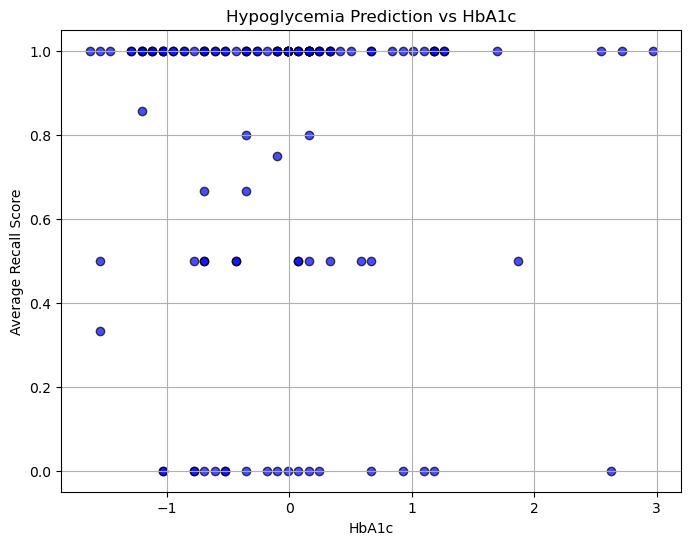

Plot saved at: /home/ma98/results/holdoutResultsFull/Night2/loss_auc_accuracy_plot.png


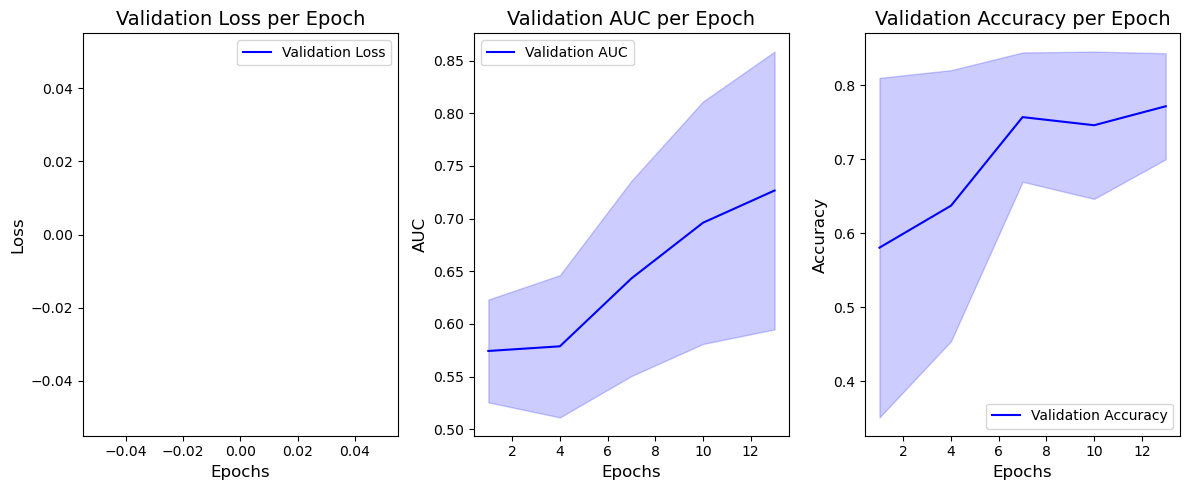

In [8]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=15, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/target_results.npy"
np.save(saved_results, target_results)



382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 0.5830723137682147, 1: 3.509426229508197}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - AUC: 0.4903 - accuracy: 0.5404 - loss: 3.6676 - val_AUC: 0.6172 - val_accuracy: 0.2632 - val_loss: 3.0026 - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.5232 - accuracy: 0.5040 - loss: 3.0371 - val_AUC: 0.7415 - val_accuracy: 0.4925 - val_loss: 2.8030 - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - AUC: 0.5234 - accuracy: 0.5003 - loss: 2.8294 - val_AUC: 0.7593 - val_accuracy: 0.6241 - val_loss: 2.6108 - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.6045 - accuracy: 0.5827 - loss: 2.6057 - val_AUC: 0.8383 - val_accuracy: 0.5583 - val_loss: 2.4097 - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - AUC: 0.7322 - accuracy: 0.6315 - loss: 

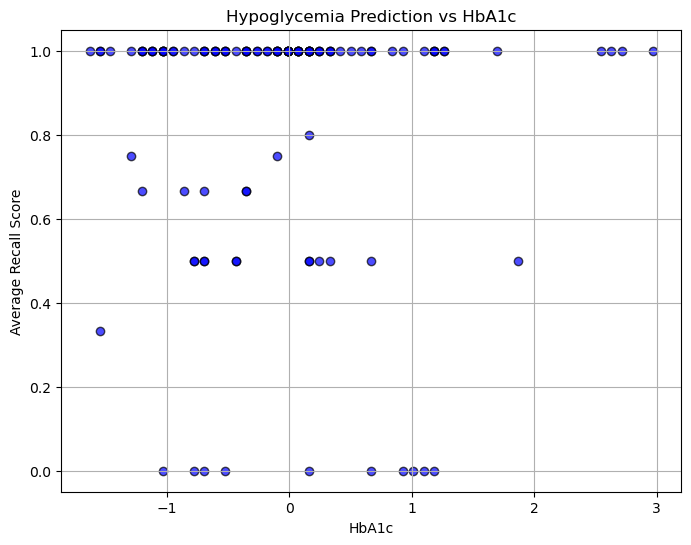

Plot saved at: /home/ma98/results/holdoutResultsFull/Night2/loss_auc_accuracy_plot.png


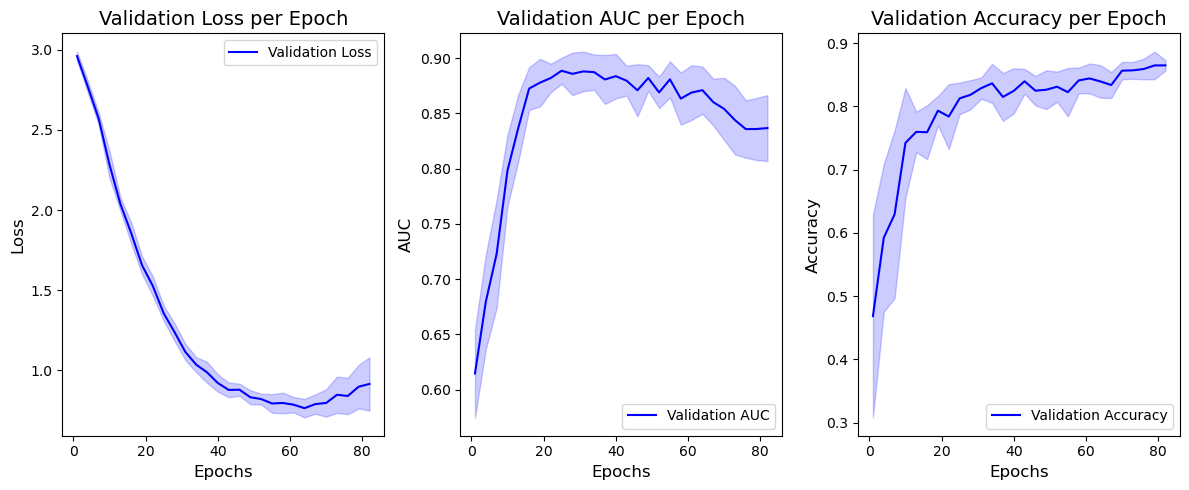

In [4]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night2"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night2/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night2/target_results.npy"
np.save(saved_results, target_results)



In [ ]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/target_results.npy"
np.save(saved_results, target_results)

